In [48]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [49]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [50]:
import os

#PATH = "../blockchainnode/db_nodes"
PATH = "/mnt/c/Temp/PoS_20221125_152153"
fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
fdbs.sort()
print(fdbs)

['/mnt/c/Temp/PoS_20221125_152153/7031.db', '/mnt/c/Temp/PoS_20221125_152153/7032.db', '/mnt/c/Temp/PoS_20221125_152153/7033.db', '/mnt/c/Temp/PoS_20221125_152153/7034.db', '/mnt/c/Temp/PoS_20221125_152153/7035.db', '/mnt/c/Temp/PoS_20221125_152153/7036.db', '/mnt/c/Temp/PoS_20221125_152153/7037.db', '/mnt/c/Temp/PoS_20221125_152153/7038.db']


[28, 24, 20, 19, 23, 18, 15, 37] 184
[16, 29, 29, 18, 30, 18, 27, 16] 183
Fairness Proof 0.9159369527145359
Fairness Verification 0.9271815189954309
Entropy Proof 0.9820425162114539
Entropy Verification 0.9834320440983392


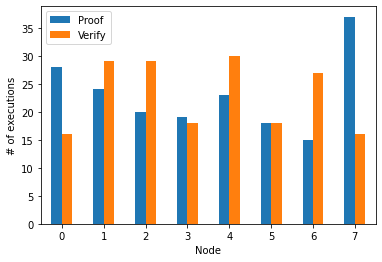

In [51]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof, verif]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
print('Entropy Verification', entropynorm(verif))




[16.404361, 5.623605958333333, 4.035757, 5.100337, 3.7959746521739133, 5.881059333333333, 13.686673599999999, 6.853412648648648]
[7160.477591625, 6944.836372586206, 6480.079092103448, 7389.829765111111, 6343.100727766667, 6948.459725277778, 6966.981564592592, 6975.0144684375]
[567.620390125, 532.8881066206897, 618.9745032068965, 682.3559763888888, 696.9667195666667, 704.5029718333334, 651.4574326666666, 604.465607375]
Avg Proof[msec] 7.672647649061154
Avg Verif Fwd[msec] 6901.097413437537
Avg Verif Back[msec] 632.4039634728928


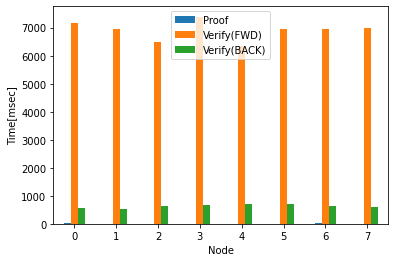

In [52]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    verifrev.append(df['timeverifrev'].mean()/unit)
print(veriffwd)
print(verifrev)

ch_list = [proof, veriffwd, verifrev]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify(FWD)', 'Verify(BACK)']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Time[msec]")

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif Fwd[msec]', sum(veriffwd)/len(veriffwd))
print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


[904.8362857142857, 900.9995, 677.0912, 979.4023157894737, 781.3537391304349, 985.2946666666667, 1196.3682666666666, 974.2361081081082]
Avg size of proof 924.9477602594544


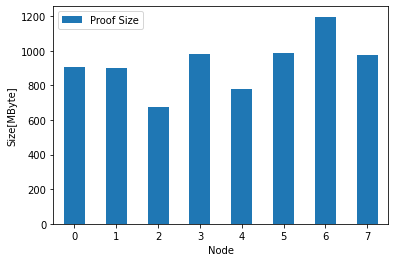

In [53]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0)
plt.xlabel("Node")
plt.ylabel("Size[MByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))


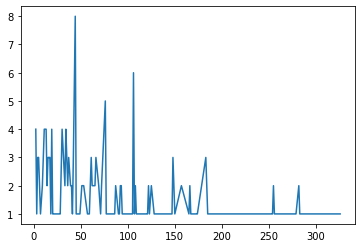

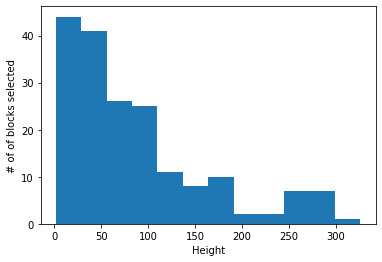

In [95]:
# List up proof block and show it in the time order 
from matplotlib import pyplot as plt

dfs = load_data_from_db(fdbs, 'prooftbl')
hash = []
for i, df in enumerate(dfs):
    for s in df['proofblock']:        
        hash.append(s)
# print(hash)

height = []
for i, df in enumerate(dfs):
    for h in df['proofheight']:        
        height.append(h)
# print(height)

ch_list = [hash, height]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Hash', 'Height']

bdf = bdf.sort_values(by=['Height'])
bdf2 = bdf.groupby(['Height'])['Height'].count().reset_index(name="Count")

plt.plot(bdf2['Height'], bdf2['Count'])

bdf = pd.DataFrame([height]).transpose()
ax = bdf.plot.hist(bins=12, label='Count')
ax.get_legend().remove()

plt.xlabel("Height")
plt.ylabel("# of of blocks selected")

plt.savefig('Proof_Blocks.png', dpi=300, bbox_inches='tight')



0.6904139641425647 0.9611661528970377
0.5925114625550457 0.9350450971508641
0.7024475349540241 0.9295188363671848


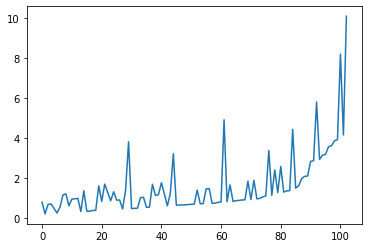

In [85]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi)
    # print(pis)
    return pis

def cal_evenness3(vdf, vmax):
    pis = cal_acc_prob(vmax)
    vdf['weight'] =  [pis[v] for v in vdf['Height'].values]
    # [pis[v] for v in vdf['Height'].values()]
    # print('weights',vdf)
    vdf['norm_cnt'] = vdf['Count']/vdf['weight']  
    values = vdf['norm_cnt'].to_list()
    
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    
    vdf['norm_cnt'].plot()
    
cal_evenness1(bdf2, 360)
cal_evenness2(bdf2, 360)
cal_evenness3(bdf2, 360)


[6.464707942236957, 5.464707942236956, 4.964707942236952, 4.631374608903619, 4.381374608903622, 4.181374608903625, 4.014707942236958, 3.871850799379815, 3.7468507993798155, 3.6357396882687043, 3.5357396882687038, 3.4448305973596125, 3.3614972640262795, 3.2845741871032037, 3.2131456156746325, 3.146478949007966, 3.0839789490079657, 3.0251554195962007, 2.969599864040645, 2.9169682850932763, 2.866968285093277, 2.819349237474229, 2.773894692019684, 2.7304164311501196, 2.6887497644834526, 2.648749764483453, 2.6102882260219142, 2.573251188984876, 2.5375369032705897, 2.5030541446499006, 2.4697208113165674, 2.437462746800438, 2.406212746800437, 2.3759097164974072, 2.346497951791525, 2.317926523220096, 2.290148745442318, 2.2631217184152908, 2.2368059289416067, 2.211164903300581, 2.1861649033005808, 2.161774659398141, 2.137965135588617, 2.1147093216351296, 2.0919820489078567, 2.069759826685635, 2.048020696250852, 2.0267441005061713, 2.0059107671728382, 1.985502603907532, 1.965502603907532, 1.9458